In [1]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf

In [2]:
import os
import pandas as pd
import numpy as np
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

In [3]:
spark=SparkSession.builder\
 .master("local[*]")\
 .appName("Linear_Regression")\
 .getOrCreate()
sc=spark.sparkContext

In [4]:
used_car = spark.read.csv(path='/home/hadoop/Downloads/used_car_new.csv', header = True, inferSchema=True)
used_car.printSchema()

root
 |-- Sr: integer (nullable = true)
 |-- Price: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Mileage: integer (nullable = true)
 |-- NewCity: string (nullable = true)
 |-- NewState: string (nullable = true)
 |-- NewMake: string (nullable = true)
 |-- NewModel: string (nullable = true)



In [5]:
used_car = used_car.drop("Sr")

In [6]:
# import the required functions
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.sql.functions import col
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

In [7]:
# Create StringIndexer objects to convert categorical columns to numerical indices
city_indexer = StringIndexer(inputCol="NewCity", outputCol="CityIndex")
state_indexer = StringIndexer(inputCol="NewState", outputCol="StateIndex")
make_indexer = StringIndexer(inputCol="NewMake", outputCol="MakeIndex")
model_indexer = StringIndexer(inputCol="NewModel", outputCol="ModelIndex")

# Fit and transform the DataFrame using the StringIndexers
used_car = city_indexer.fit(used_car).transform(used_car)  # Convert "NewCity" column to numerical indices and store in "CityIndex" column
used_car = state_indexer.fit(used_car).transform(used_car)  # Convert "NewState" column to numerical indices and store in "StateIndex" column
used_car = make_indexer.fit(used_car).transform(used_car)  # Convert "NewMake" column to numerical indices and store in "MakeIndex" column
used_car = model_indexer.fit(used_car).transform(used_car)  # Convert "NewModel" column to numerical indices and store in "ModelIndex" column

# Show the first 10 rows of the transformed DataFrame
used_car.show(10)

+-----+----+-------+----------+----------+-----------+-----------+---------+----------+---------+----------+
|Price|Year|Mileage|   NewCity|  NewState|    NewMake|   NewModel|CityIndex|StateIndex|MakeIndex|ModelIndex|
+-----+----+-------+----------+----------+-----------+-----------+---------+----------+---------+----------+
|22900|2017|   5363|  CLimited|SPlentiful|MAPlentiful| MOIsolated|      1.0|       0.0|      0.0|       1.0|
|14000|2011| 107273|CPlentiful|SPlentiful|MAPlentiful| MOIsolated|      3.0|       0.0|      0.0|       1.0|
|16795|2014|  31905| CIsolated|SPlentiful|MAPlentiful|MOPlentiful|      0.0|       0.0|      0.0|       0.0|
|11975|2010|  89254| CModerate|SPlentiful|MAPlentiful|MOPlentiful|      2.0|       0.0|      0.0|       0.0|
|12500|2009|  49160| CIsolated|SPlentiful|MAPlentiful| MOModerate|      0.0|       0.0|      0.0|       2.0|
|13712|2015|  51619| CIsolated|SPlentiful|MAPlentiful| MOIsolated|      0.0|       0.0|      0.0|       1.0|
|14995|2014|  81080

In [8]:
# Create a VectorAssembler to combine specified columns into a single feature vector
assembler = VectorAssembler(
    inputCols=["Mileage", "Year", "CityIndex", "StateIndex", "MakeIndex", "ModelIndex"],
    outputCol="features"
)

# Transform the DataFrame using the VectorAssembler
used_car = assembler.transform(used_car)

# Drop the original categorical columns from the DataFrame
used_car = used_car.drop("NewCity", "NewState", "NewMake", "NewModel")

# Split the DataFrame into training (70%) and testing (30%) sets using a random seed for reproducibility
train, test = used_car.randomSplit([0.7, 0.3], seed=123)

# Show the first 10 rows of the transformed DataFrame
used_car.show(10)


+-----+----+-------+---------+----------+---------+----------+--------------------+
|Price|Year|Mileage|CityIndex|StateIndex|MakeIndex|ModelIndex|            features|
+-----+----+-------+---------+----------+---------+----------+--------------------+
|22900|2017|   5363|      1.0|       0.0|      0.0|       1.0|[5363.0,2017.0,1....|
|14000|2011| 107273|      3.0|       0.0|      0.0|       1.0|[107273.0,2011.0,...|
|16795|2014|  31905|      0.0|       0.0|      0.0|       0.0|(6,[0,1],[31905.0...|
|11975|2010|  89254|      2.0|       0.0|      0.0|       0.0|[89254.0,2010.0,2...|
|12500|2009|  49160|      0.0|       0.0|      0.0|       2.0|[49160.0,2009.0,0...|
|13712|2015|  51619|      0.0|       0.0|      0.0|       1.0|[51619.0,2015.0,0...|
|14995|2014|  81080|      2.0|       0.0|      0.0|       0.0|[81080.0,2014.0,2...|
|17970|2013|  50533|      0.0|       0.0|      0.0|       0.0|(6,[0,1],[50533.0...|
|27288|2015|  22873|      0.0|       0.0|      0.0|       0.0|(6,[0,1],[2287

In [9]:
# Create a Linear Regression model
target_column='Price'
lr = LinearRegression(featuresCol='features', labelCol=target_column)

# Fit the DecisionTreeRegressor model to the training data
model = lr.fit(train)

# Make predictions on the test data using the trained model
predictions = model.transform(test)

23/04/19 15:51:45 WARN Instrumentation: [1aba1c11] regParam is zero, which might cause numerical instability and overfitting.
23/04/19 15:51:46 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/04/19 15:51:46 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
23/04/19 15:51:46 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
23/04/19 15:51:46 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


In [10]:
# Create a RegressionEvaluators with the R2,RMSE,  and MAE metrics
r2_evaluator = RegressionEvaluator(predictionCol='prediction', labelCol=target_column, metricName='r2')
rmse_evaluator = RegressionEvaluator(predictionCol='prediction', labelCol=target_column, metricName='rmse')
mae_evaluator = RegressionEvaluator(predictionCol='prediction', labelCol=target_column, metricName='mae')
mse_evaluator = RegressionEvaluator(predictionCol='prediction', labelCol=target_column, metricName='mse')

# Calculate the R2,RMSE,and MAE scores on the test data
r2 = r2_evaluator.evaluate(predictions)
rmse = rmse_evaluator.evaluate(predictions)
mae = mae_evaluator.evaluate(predictions)
mse = mse_evaluator.evaluate(predictions)

#print results
print("R2:", r2)
print("RMSE:", rmse)
print("MAE:", mae)
print("MSE:", mse)


R2: 0.21401167185768233
RMSE: 11864.017566994213
MAE: 7763.088031428788
MSE: 140754912.8299473


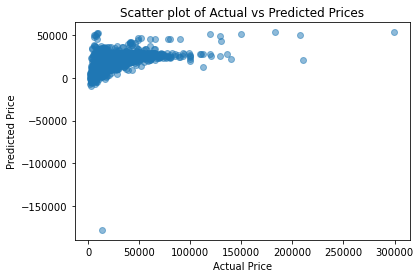

In [12]:
# create scatter plot
import matplotlib.pyplot as plt

# create scatter plot
plt.scatter(predictions.select('Price').collect(),
            predictions.select('prediction').collect(),
            alpha=0.5)

plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Scatter plot of Actual vs Predicted Prices')
# Save the scatter plot to a file (e.g., 'scatter_plot.png')
plt.savefig('scatterplot_LM_HPCI.png' , dpi=200, bbox_inches='tight')

plt.show()

In [13]:
# Drop the "CityIndex", "StateIndex", and "features" columns from the DataFrame
used_car = used_car.drop("CityIndex", "StateIndex", "features")
# Show the first 10 rows of the DataFrame
used_car.show(10)

# Create a new VectorAssembler to combine the specified columns into a single feature vector
assembler = VectorAssembler(
    inputCols=["Mileage", "Year", "MakeIndex", "ModelIndex"],
    outputCol="features"
)

# Transform the DataFrame using the new VectorAssembler
used_car = assembler.transform(used_car)

# Split the DataFrame into training (70%) and testing (30%) sets using a random seed for reproducibility
train, test = used_car.randomSplit([0.7, 0.3], seed=123)

lr = LinearRegression(featuresCol='features', labelCol=target_column)

# Fit the DecisionTreeRegressor model to the training data
model = lr.fit(train)

# Make predictions on the test data using the trained model
predictions = model.transform(test)

# Calculate the R2,RMSE,and MAE scores on the test data
r2 = r2_evaluator.evaluate(predictions)
rmse = rmse_evaluator.evaluate(predictions)
mae = mae_evaluator.evaluate(predictions)
mse = mse_evaluator.evaluate(predictions)

#print results
print("R2:", r2)
print("RMSE:", rmse)
print("MAE:", mae)
print("MSE:", mse)


+-----+----+-------+---------+----------+
|Price|Year|Mileage|MakeIndex|ModelIndex|
+-----+----+-------+---------+----------+
|22900|2017|   5363|      0.0|       1.0|
|14000|2011| 107273|      0.0|       1.0|
|16795|2014|  31905|      0.0|       0.0|
|11975|2010|  89254|      0.0|       0.0|
|12500|2009|  49160|      0.0|       2.0|
|13712|2015|  51619|      0.0|       1.0|
|14995|2014|  81080|      0.0|       0.0|
|17970|2013|  50533|      0.0|       0.0|
|27288|2015|  22873|      0.0|       0.0|
|10030|2014|  51338|      0.0|       2.0|
+-----+----+-------+---------+----------+
only showing top 10 rows



23/04/19 15:52:55 WARN Instrumentation: [8f38f85a] regParam is zero, which might cause numerical instability and overfitting.


R2: 0.21387665086453223
RMSE: 11865.036553274274
MAE: 7764.073309364344
MSE: 140779092.41053468
